# SHG experiments

Author: Luis Ledezma (ledezma@caltech.edu)

The goal of this notebook is to...

## The code

We begin by importing the modules needed, including my own. I also do some formatting. You can safely ignore all this.

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
import time
from scipy import fftpack as sp
from scipy import signal
import copy
from matplotlib import cm
import colorcet as cc
from matplotlib.colors import Normalize

#This are my libraries
import nlo 
import materials
import waveguides
from util import sech

#Larger font for plots
plt.rcParams.update({'font.size': 18})

## Units
We'll work in SI base units for the most part. Here we load some constants and also create some variables for scaling units conveniently.

In [2]:
from scipy.constants import pi, c, epsilon_0
pm = 1e-12
nm = 1e-9
um = 1e-6
mm = 1e-3
ps = 1e-12
fs = 1e-15
GHz = 1e9
THz = 1e12

## Time and Frequency domain windows

### General Comments
We need to determine the FFT size $N$, as well the size of the time window $T$ and the total frequency bandwidth $F_\mathrm{BW}$. Both domain will have $N$ points, and these three parameters are related by the uncertainty relations:

$${\Delta t} {\Delta f } = \frac{1}{N}, \\
T F_{\mathrm{BW}} = N.$$

We should make sure that the time and frequency windows are large enough that all important dynamics occur inside them. Obviously, we can order enlarge both at the same time by increasing $N$, and this is computationally costly.

The size of the time window $T$ depends on the group velocity of the pulses propagating in it. It needs to be large enough so that no part of the pulses reach the edge of the domain at any point. Since we will pick the velocity of the moving reference frame, how much the pulses travel depends on the respective group velocity mismatches of all the frequency components with respect to the frame reference velocity. We can get his information from the group velocity mismatch across the frequency bandwidth.

Choosing the frequency window is more complicated since in general we don't know what part of the new generated frequencies are relevant. In practice there will be cascading effects as the pulses travel down the nonlinear crystal. It may be necessary to iteratively narrowdown on what is a good bandwidth for a particular application.

### SHG Example
For this example we'll choose the bandwidth large enough to cover just the fundamental and second harmonics. We can then play with the number of points $N$ until we get a window size that is at least 3 ps long (since that's about what's shown in the paper results). If we didn't know that we could try to guess, run the simulation, check how much the pulse travels, adjust, and so on.

In [3]:
wl_ff = 1400*nm #Fundamental wavelength
f0_ff = c/wl_ff
f0_sh = 2*f0_ff #SHG frequency
wl_sh = c/f0_sh

#In this example we only care about fundamental and second harmonic,
#so, let's set the bandwidth accordingly
f_min = c/(5*um)
f_max = c/(500*nm)
BW = f_max - f_min

#Now we can create the time and frequency arrays
NFFT = 2**12
Tmax = NFFT/BW
dt = 1/BW
t_start = -4*ps
t_stop = t_start + NFFT*dt
t = np.arange(t_start, t_stop, step=dt)
f = fftfreq(NFFT, dt)
Omega = 2*pi*f
df = f[1]-f[0]

We also need to choose a reference frequency $f_{ref}$. Our simulation is a bandpass simulation centered around this reference frequency. So, the natural frequency variable for our simulation is $$\Omega = \omega - \omega_{ref}.$$
I'll try to be consistent and use lower case variable names for absolute frequencies representing $\omega$'s, and variable names starting with an uppper case to represent $\Omega$. For, instance, the variable ```Omega``` that we just created represents $\Omega$, while in the next cell we'll define ```omega_ref``` and ```omega_abs``` which represents $\omega_{ref}$ and $\omega$.

In the next cell we define $f_{ref}$ as the mean frequency between the fundamental and second harmonic. We also define arrays with absolute frequencies, and find the min and max frequencies and wavelengths of our simulation. We may be interested later in knowing things at exactly the fundamental and second harmonics, so having get their indexes is useful. Finally we print everything out for verification.

In [4]:
#Reference frequency
f_ref = (f_min + f_max)/2
wl_ref = c/f_ref
omega_ref = 2*pi*f_ref

#Absolute frequencies and wavelengths
f_abs = f + f_ref
wl_abs = c/f_abs
omega_abs = 2*pi*f_abs
f_min = np.amin(f_abs)
f_max = np.amax(f_abs)
wl_max = c/f_min
wl_min = c/f_max

#get the frequency indexes for fundamental and second harmonics
f0_ff_index = np.abs(f + f_ref - f0_ff).argmin()
f0_sh_index = np.abs(f + f_ref - f0_sh).argmin()
f_ref_index = np.abs(f).argmin()

print('Fundamental wavelength = %0.1f nm' %(wl_ff/nm))
print('SH wavelength = %0.1f nm' %(wl_sh/nm))
print('Fundamental frequency = %0.1f THz' %(f0_ff/THz))
print('SH frequency = %0.1f THz' %(f0_sh*1e-12))
print('Simulation bandwidth = %0.1f THz' %(BW/THz))
print('Time window size = %0.3f ps' %(Tmax/ps))
print('Sampling Rate = %0.3f fs' %(dt/fs))
print('Frequency Resolution = %0.3f GHz' %(df/GHz))
print('Reference wavelength = %0.1f nm' %(wl_ref/nm))
print('Reference frequency = %0.1f THz' %(f_ref/THz))
print('Minimum absolute frequency = %0.1f THz' %(f_min/THz))
print('Maximum absolute frequency = %0.1f THz' %(f_max/THz))
print('Minimum absolute wavelength = %0.1f nm' %(c/f_max/nm))
print('Maximum absolute wavelength = %0.1f um' %(c/f_min/nm))
print('Array index for fundamental = %i' %(f0_ff_index))
print('Array index for SH = %i' %(f0_sh_index))
print('Array index for reference = %i' %(f_ref_index))

Fundamental wavelength = 1400.0 nm
SH wavelength = 700.0 nm
Fundamental frequency = 214.1 THz
SH frequency = 428.3 THz
Simulation bandwidth = 539.6 THz
Time window size = 7.590 ps
Sampling Rate = 1.853 fs
Frequency Resolution = 131.745 GHz
Reference wavelength = 909.1 nm
Reference frequency = 329.8 THz
Minimum absolute frequency = 60.0 THz
Maximum absolute frequency = 599.5 THz
Minimum absolute wavelength = 500.1 nm
Maximum absolute wavelength = 5000.0 um
Array index for fundamental = 3218
Array index for SH = 748
Array index for reference = 0


## Material properties

I'm going to load the refractive index of lithium tantalate from my personal library named <font color=magenta> materials</font>. In that library I implement mostly Sellmeier's equations obtained from https://refractiveindex.info/ for a few common materials.

Refractive index at fundamental = 2.134
Refractive index at second harmonic = 2.180 


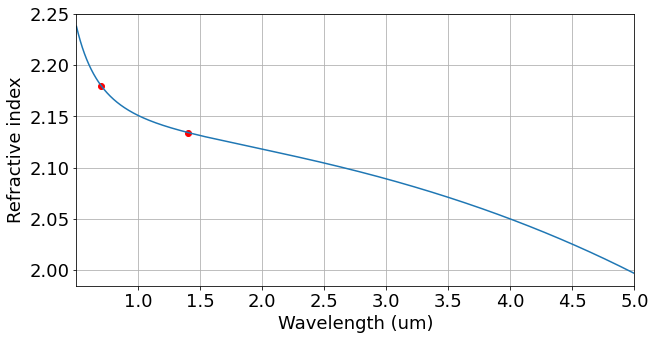

In [5]:
def n_func(wl):
    n = materials.refractive_index('LN_MgO_e', wl/um)
    return n

nLN = n_func(wl_abs)
nw = nLN[f0_ff_index]
n2w = nLN[f0_sh_index]

plt.rcParams['figure.figsize'] = [10, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(fftshift(wl_abs/um), fftshift(nLN))
ax1.scatter(wl_abs[f0_ff_index]/um, nw, c='r')
ax1.scatter(wl_abs[f0_sh_index]/um, n2w, c='r')
ax1.set_xlim([wl_min/um, wl_max/um])
# ax1.set_ylim([2.1,2.2])
ax1.set_xlabel('Wavelength (um)')
ax1.set_ylabel('Refractive index')
ax1.grid(True)

print('Refractive index at fundamental = %0.3f' %(nw))
print('Refractive index at second harmonic = %0.3f ' %(n2w))

Now we'll get the propagation constant as usual:
$$ \beta = \frac{\omega n}{c} ,$$

as well as the group velocity and GVD:
$$ 
v_g = \frac{1}{\beta_1} = \left( \frac{\partial \beta}{\partial \omega} \right)^{-1} \\
\mathrm{GVD} = \beta_2 = \frac{\partial^2 \beta}{\partial \omega^2} .
$$

We also need to get the higher order dispersion operator; this can be obtained from the propagation constant as follows:
$$D = \beta(\Omega) - \beta \big|_{\Omega=0} - \frac{\Omega}{v_{ref}}.$$

For this example we'll use $v_{ref} = v_g(2 \omega_0)$.

At this point we can also compute the GVM ($\Delta \beta^\prime $) between the fundamental signal and the moving reference frame:
$$ \Delta \beta^\prime = \frac{1}{v_{ref}} - \frac{1}{v_g(\omega_0)}, $$
and then we can compute how much a pulse at $\omega_0$ will travel in a crystal of length $L$,
$$ \tau =  L \Delta \beta^\prime. $$

GVD at 0.909 um = 296.333 fs^2/mm
GVD at 1.400 um = 133.885 fs^2/mm
Group velocity mismatch between 1.40 um wave and reference frame = 0.386 ps/mm


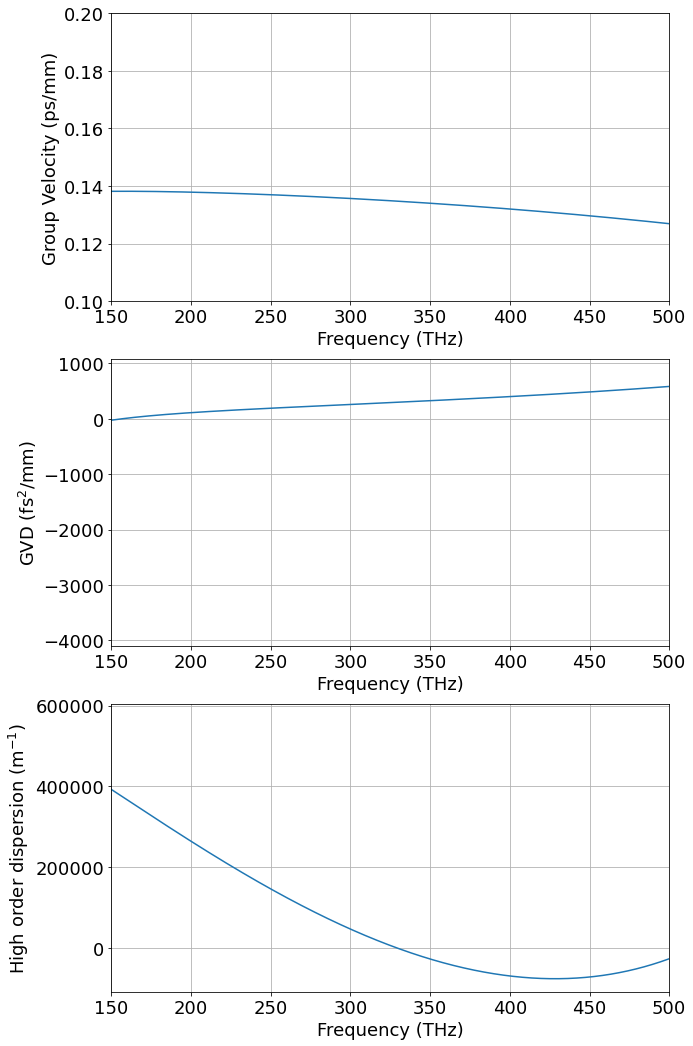

In [6]:
beta = omega_abs*nLN/c
beta_1 = fftshift(np.gradient(fftshift(beta), 2*pi*df))
beta_2 = fftshift(np.gradient(fftshift(beta_1), 2*pi*df))
vg = 1/beta_1

beta_ref = beta[0]
v_ref = vg[f0_sh_index]
D = beta - beta_ref - Omega/v_ref

plt.rcParams['figure.figsize'] = [10, 18]
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.plot(fftshift(f_abs)/THz, fftshift(vg)/(mm/ps));
ax2.plot(fftshift(f_abs)/THz, fftshift(beta_2)/(fs**2/mm));
ax1.set_ylabel('Group Velocity (ps/mm)'); ax2.set_ylabel('GVD (fs$^2$/mm)')
ax1.set_xlabel('Frequency (THz)'); ax2.set_xlabel('Frequency (THz)');
ax1.set_xlim(150, 500); ax2.set_xlim(150, 500)
ax1.set_ylim(0.1,0.2)
ax1.grid(True); ax2.grid(True)
ax3.plot(fftshift(f_abs)/THz, fftshift(D));
ax3.set_xlabel('Frequency (THz)');
ax3.set_ylabel('High order dispersion (m$^{-1}$)');
ax3.grid(True)
ax3.set_xlim(150, 500);

#Some extra information
GVM = 1/v_ref - 1/vg[f0_ff_index]

print('GVD at %0.3f um = %0.3f fs^2/mm' %(wl_ref*1e6, beta_2[0]*1e27))
print('GVD at %0.3f um = %0.3f fs^2/mm' %(wl_ff*1e6, beta_2[f0_ff_index]*1e27))
print('Group velocity mismatch between %0.2f um wave and reference frame = %0.3f ps/mm' %(wl_ff*1e6, GVM/(ps/mm)))

## Quasi Phase Matching

We can get the ideal poling period for SHG is:
$$
\Lambda = \frac{\lambda_{2\omega}}{n_{2\omega} - n_\omega}
$$

In [7]:
poling_period = (wl_sh)/(n2w-nw)
print('Optimal Poling period for SHG starting from pump at %0.2f um is %0.2f um' %(wl_ff*1e6, poling_period*1e6))

# poling_period = 17.4*um

delta_b = 2*beta[f0_ff_index] - beta[f0_sh_index]
print('Phase mismatch before poling = %0.1f 1/m' %(delta_b))
print('Phase mismatch after poling = %0.2f 1/m' %(delta_b+2*pi/poling_period))

Optimal Poling period for SHG starting from pump at 1.40 um is 15.34 um
Phase mismatch before poling = -414951.7 1/m
Phase mismatch after poling = -5278.45 1/m


We can modulate the nonlinearity as function of distance using this period. What I want is a function that returns $\chi^{(2)}$ vs distance. I call this function ```chi2```. In this example I'm using a first order grating since this is what they used in [1].

In [8]:
d33 = 10.6e-12
deff = d33
pp = poling_period

def chi2(z):
#     poling = (2/pi)*np.cos(z*2*pi/pp)
    
    poling = 1
    return 2*deff*poling


# #Let's look at it
# plt.rcParams['figure.figsize'] = [10, 5]
# z = np.arange(0, 50*um, 0.1*um)
# plt.plot(z/um, chi2(z)/pm)
# plt.xlabel('Distance ($\mu$m)')
# plt.ylabel('$\chi^{(2)}$ (pm/V)')

## Nonlinear  Component
Now we create a nonlinear component based on this refractive index and propagation constant. This nonlinear component implements a method for propagation using the NEE.

In [9]:
crystal = nlo.nonlinear_element(L=5*mm, n_func=n_func, chi2=chi2)

## Input pulse creation

We can find the peak value of the pulse from the intensity
$$
E_p = \sqrt{\frac{2 I}{n_\omega c \epsilon_0}}.
$$

The reference frequency $\omega_{ref}$ is mapped to zero in $\Omega$. So, to generate a pulse at frequency $\omega_0$ we need to modulate it:
$$
p(t) e^{j (\omega_0 - \omega_{ref}) t} = p(t) e^{j \Omega_0 t}.
$$

Let's now generate the pulse, add a bit of noise to it, and plot it to verify it is at the right frequency and looks like we expect it to look.

Here I introduce a class named ```pulse```, the goal is to pack everything relevant to the pulse into a single object, just like we did with ```nonlinear_element```. I also have a bunch of convenience methods associated with ```pulse``` for things like plotting, calculating FWHM, energy, etc.

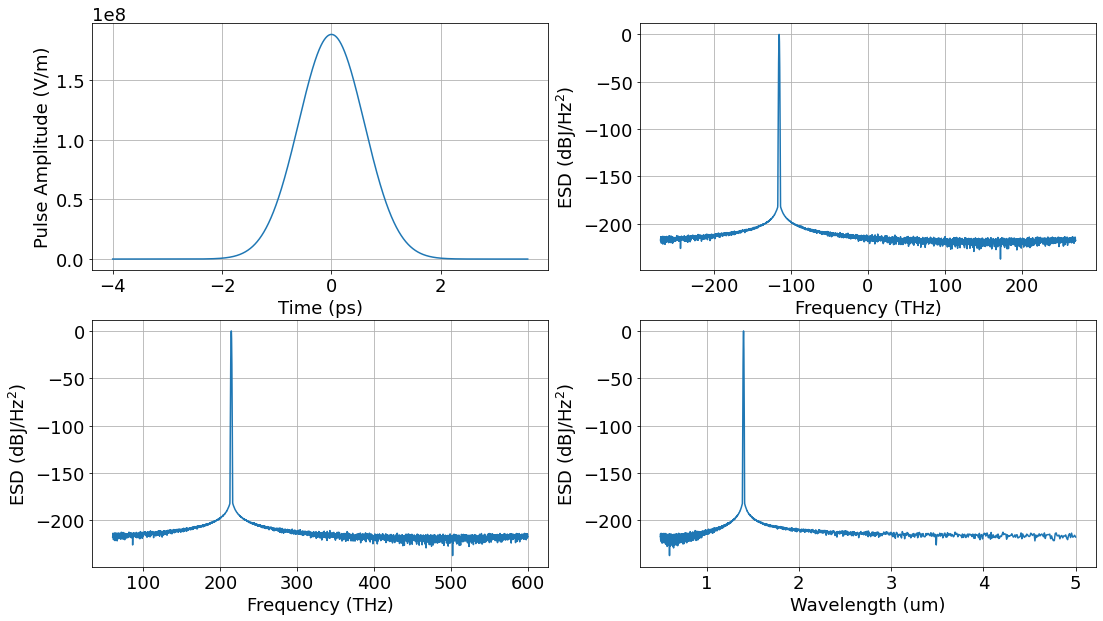

In [10]:
#Frequency offset from reference:
Omega_0 = 2*pi*(f0_ff - f_ref)

#Peak value:
Intensity = 10e13 #10GW/cm^2
n = nw
Epeak = np.sqrt(2*Intensity/(n*c*epsilon_0))

#Pulse width:
# tau = 60e-15 
tau = 1*ps

#Noise floor
noise = 0.01*np.random.normal(size=NFFT)

#Pulse creation
x = Epeak*np.exp(-2*np.log(2)*(t/tau)**2)*np.exp(1j*Omega_0*t)
x = x + noise
pulse = nlo.pulse(t, x, wl_ref)

plt.rcParams['figure.figsize'] = [18, 10]
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1 = pulse.plot_mag(ax=ax1, t_unit='ps'); ax1.set_ylabel('Pulse Amplitude (V/m)')
ax2 = pulse.plot_ESD_dB(ax=ax2, label='ESD (dBJ/Hz$^2$)', f_unit = 'THz')
ax3 = pulse.plot_ESD_dB_absfreq(ax=ax3, label='ESD (dBJ/Hz$^2$)', f_unit = 'THz')
ax4 = pulse.plot_ESD_dB_vs_wavelength(ax=ax4, label='ESD (dBJ/Hz$^2$)', wl_unit='um');

## Single pass

Finally, we can run the simulation. The method ```propagate_NEE``` takes a pulse object, a step size, and a reference velocity for the moving frame and outputs a pulse and it's evolution along the crystal.

In [11]:
h = 1*mm/500 #Step size
[out_pulse, pulse_evol] = crystal.propagate_NEE(pulse, h, v_ref=v_ref)

Crystal length = 5.00 mm
Step size = 2.00 um
Number of steps = 2501
Using method = v2 (dispersive)
Completed propagation along 0.5 mm (2.8 s)
Completed propagation along 1.0 mm (2.7 s)
Completed propagation along 1.5 mm (2.7 s)
Completed propagation along 2.0 mm (2.8 s)
Completed propagation along 2.5 mm (2.7 s)
Completed propagation along 3.0 mm (2.7 s)
Completed propagation along 3.5 mm (2.7 s)
Completed propagation along 4.0 mm (2.7 s)
Completed propagation along 4.5 mm (2.7 s)
Completed propagation along 5.0 mm (2.7 s)
Total time = 27.3 s


Let's plot now the input and output pulses. Recall that the fundamental pulse will move to the left with respect to the simulation frame. The output pulse is a single envelope that contains both the fundamental and second harmonic components.

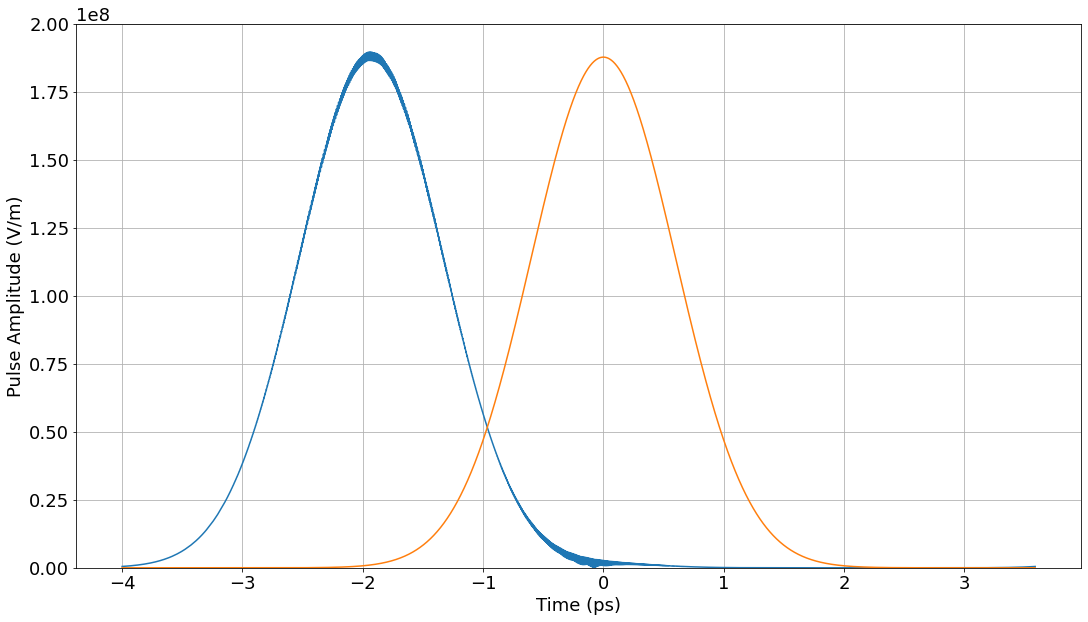

In [12]:
ax1 = nlo.plot_mag(t, out_pulse)
ax1 = pulse.plot_mag(ax=ax1)
# ax1.set_xlim(-2,0.5)
ax1.set_ylim(0,2e8)
ax1.set_ylabel('Pulse Amplitude (V/m)')
ax1.set_xlabel('Time (ps)');

We can also look at the evolution of the pulse along the crystal. Here it also clear that the input pulse travels while it creates a faint second harmonic that is stationary in the simulation frame. 

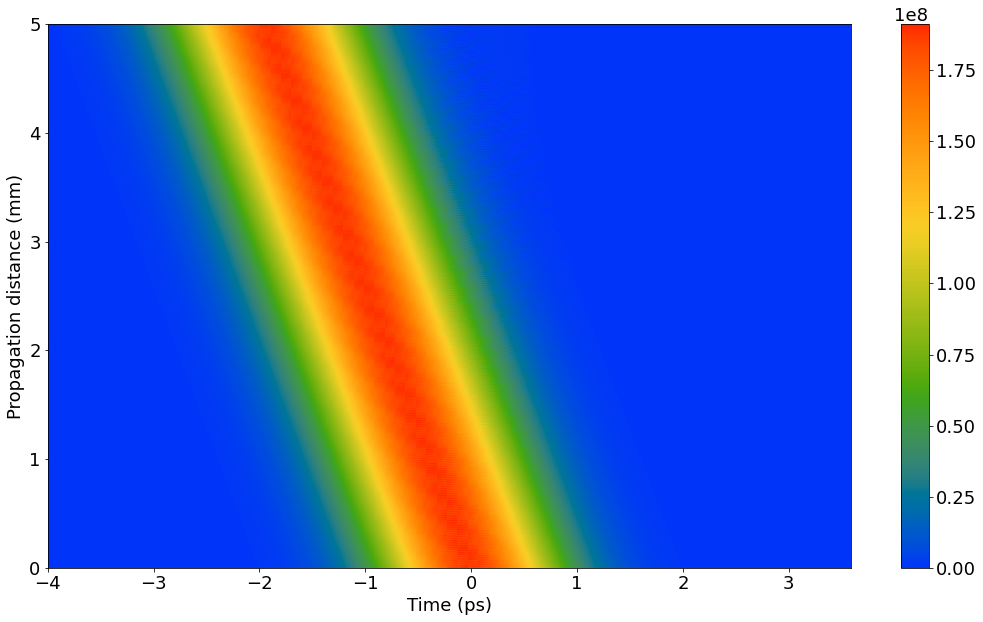

In [13]:
Nsteps = pulse_evol.shape[1]-1
X,Y = np.meshgrid(t/ps, np.arange(Nsteps+1)*h*1e3)
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(X, Y, (np.transpose(np.abs(pulse_evol))), cmap = cc.cm["rainbow"])
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Propagation distance (mm)')
ax.set_ylim([0,5])
# ax.set_xlim([-2,0.5])
plt.colorbar(im, ax=ax);

## Filter and plot harmonics

We would like to see the pulse shapes at the fundamental and second harmonic. For this we need to separate them using filters. In the cell below I first create the filters and check the spectrum to make sure they are at the right places. And on the second plot I show the results of fundamental and second harmonic pulses, as well as the input pulse for reference.

Text(0, 0.5, 'Pulse Amplitude (V/m)')

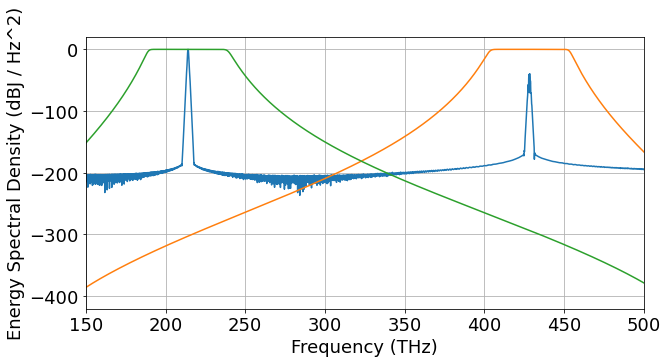

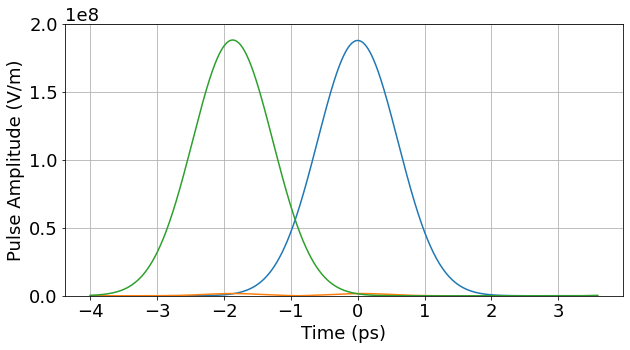

In [32]:
filter_bw = 50e12

f1 = (f0_ff - filter_bw/2 - f_min)/(f_max-f_min)
f2 = (f0_ff + filter_bw/2 - f_min)/(f_max-f_min)
sos = signal.butter(15, [f1, f2], 'bandpass', output='sos')
_, h_ff = signal.sosfreqz(sos, worN=NFFT)

f1 = (f0_sh - filter_bw/2 - f_min)/(f_max-f_min)
f2 = (f0_sh + filter_bw/2 - f_min)/(f_max-f_min)
sos = signal.butter(15, [f1, f2], 'bandpass', output='sos')
_, h_sh = signal.sosfreqz(sos, worN=NFFT)

out_sh = ifft(fft(out_pulse)*fftshift(h_sh))
out_ff = ifft(fft(out_pulse)*fftshift(h_ff))

plt.rcParams['figure.figsize'] = [10, 5]
ax1 = nlo.plot_ESD_dB_absfreq(t, out_pulse, f_ref)
ax1.plot(fftshift(f+f_ref)*1e-12, 20*np.log10(abs(h_sh + 1e-20)));
ax1.plot(fftshift(f+f_ref)*1e-12, 20*np.log10(abs(h_ff + 1e-20)))
# ax1.set_ylim([-100,10])
ax1.set_xlim([150, 500])

plt.rcParams['figure.figsize'] = [10, 5]
ax1 = pulse.plot_mag()
ax1 = nlo.plot_mag(t, out_sh, ax=ax1)
ax1 = nlo.plot_mag(t, out_ff, ax=ax1)
# ax1.set_xlim(-2.5,0.5)
ax1.set_ylim(0, 2e8)
ax1.set_ylabel('Pulse Amplitude (V/m)')

## Spectrum

We can look at the pulse evolution along the crystal also in the frequency domain.

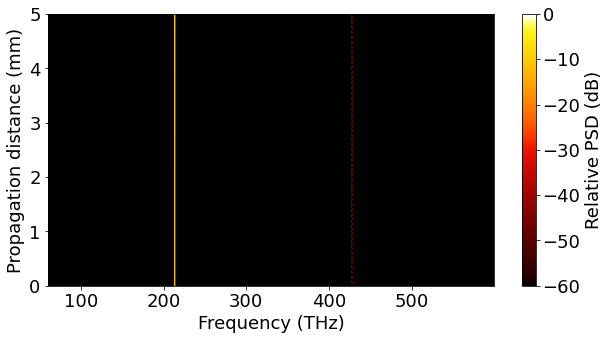

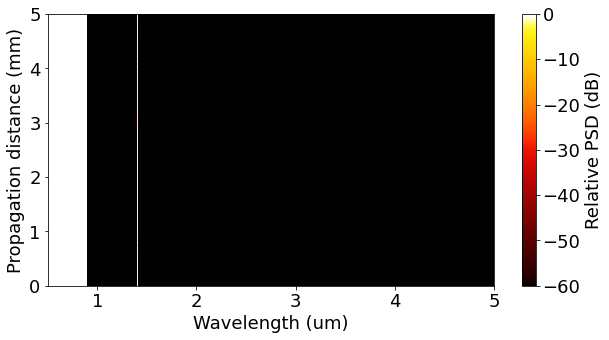

In [15]:
A_evol = np.zeros((t.size, Nsteps+1))

for k in range(Nsteps+1):
    x = pulse_evol[:,k]
    _ , Aesd = nlo.get_esd(t, x)
    A_evol[:,k] = 10*np.log10(Aesd)

A_evol = A_evol - np.amax(A_evol)
A_evol = fftshift(A_evol, axes=0)

X,Y = np.meshgrid(fftshift(f+f_ref)*1e-12, np.arange(Nsteps+1)*h*1e3)
plt.figure()
plt.pcolormesh(X, Y, (np.transpose(A_evol)), cmap = cc.cm["fire"], vmin=-60, vmax=0)
cb = plt.colorbar()
cb.set_label('Relative PSD (dB)')
plt.xlabel('Frequency (THz)')
plt.ylabel('Propagation distance (mm)');

wl_array = c/(fftshift(f)+f_ref)*1e6
Xwl,Ywl = np.meshgrid(wl_array, np.arange(Nsteps+1)*h*1e3)
plt.figure()
plt.pcolormesh(Xwl, Ywl, (np.transpose(A_evol)), cmap = cc.cm["fire"], vmin=-60, vmax=0)
cb = plt.colorbar()
cb.set_label('Relative PSD (dB)')
plt.xlabel('Wavelength (um)')
plt.ylabel('Propagation distance (mm)');

Let's check how the second harmonic energy evolves along the crystal

In [16]:
h_ff_tiled = np.tile(h_ff, (pulse_evol.shape[1],1)).transpose()

out_ff = ifft(fft(pulse_evol, axis=0)*fftshift(h_ff_tiled, axes=0), axis=0)

pwr_ff = abs(out_ff)**2
energy_ff = np.sum(pwr_ff, axis=0)*dt

In [17]:
h_sh_tiled = np.tile(h_sh, (pulse_evol.shape[1],1)).transpose()

out_sh = ifft(fft(pulse_evol, axis=0)*fftshift(h_sh_tiled, axes=0), axis=0)

pwr_sh = abs(out_sh)**2
energy_sh = np.sum(pwr_sh, axis=0)*dt

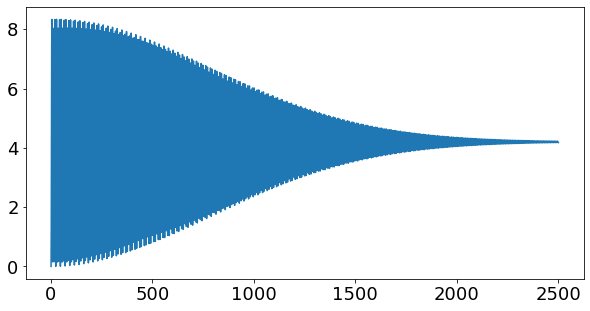

In [28]:
# plt.plot(energy_ff)
plt.plot(energy_sh)

## References
[1] M. Conforti, F. Baronio, and C. De Angelis, “Nonlinear envelope equation for broadband optical pulses in quadratic media,” Phys. Rev. A, vol. 81, no. 5, p. 053841, May 2010, doi: 10.1103/PhysRevA.81.053841.

# <center> END OF DOCUMENT </center>

In [21]:
# #Formatting stuff
# from IPython.core.display import HTML
# def css_styling():
#     styles = open("custom.css", "r").read()
#     return HTML(styles)
# css_styling()

### Software Versions

In [22]:
%load_ext version_information
%version_information scipy, numpy, matplotlib

Software versions
Python 3.7.6 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.13.0
OS Windows 10 10.0.16299 SP0
scipy 1.4.1
numpy 1.18.1
matplotlib 3.2.1
Mon Apr 20 17:48:45 2020 Pacific Daylight Time

### Animation Generation

In [23]:
# %matplotlib inline
# from matplotlib import animation, rc
# # from IPython.display import HTML

# # First set up the figure, the axis, and the plot element we want to animate
# fig, ax = plt.subplots()

# ax.set_xlim(( -2, 0.5))
# ax.set_ylim((0, 2e8))
# ax.set_ylabel('Pulse Amplitude $\sqrt{W}$')
# ax.set_xlabel('Time (ps)')

# line, = ax.plot([], [], lw=2)

# # initialization function: plot the background of each frame
# def init():
#     line.set_data([], [])
#     return (line,)

# # animation function. This is called sequentially
# def animate(i):
#     line.set_data(t*1e12, np.abs(a_evol[:,5*i]))
#     return (line,)

# # call the animator. blit=True means only re-draw the parts that have changed.
# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=int(Nsteps/5), interval=20, blit=True)

# rc('animation', html='html5')
# anim